Found 2560 images belonging to 1 classes.
Found 641 images belonging to 1 classes.

✅ Class Weights computed: {0: 1.0}


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9961 - loss: 0.1482

80/80 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9962 - loss: 0.1470 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 731ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 809ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 7.9912e-04 - learning_rate: 0.0010
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 797ms/step - accuracy: 1.0000 - loss: 9.4057e-04 - val_accuracy: 1.0000 - val_loss: 5.7732e-04 - learning_rate: 0.0010
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 806ms/step - accuracy: 1.0000 - loss: 6.6499e-04 - val_accuracy: 1.0000 - val_loss: 4.3997e-04 - learning_rate: 0.0010
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - accuracy: 1.0000 - l

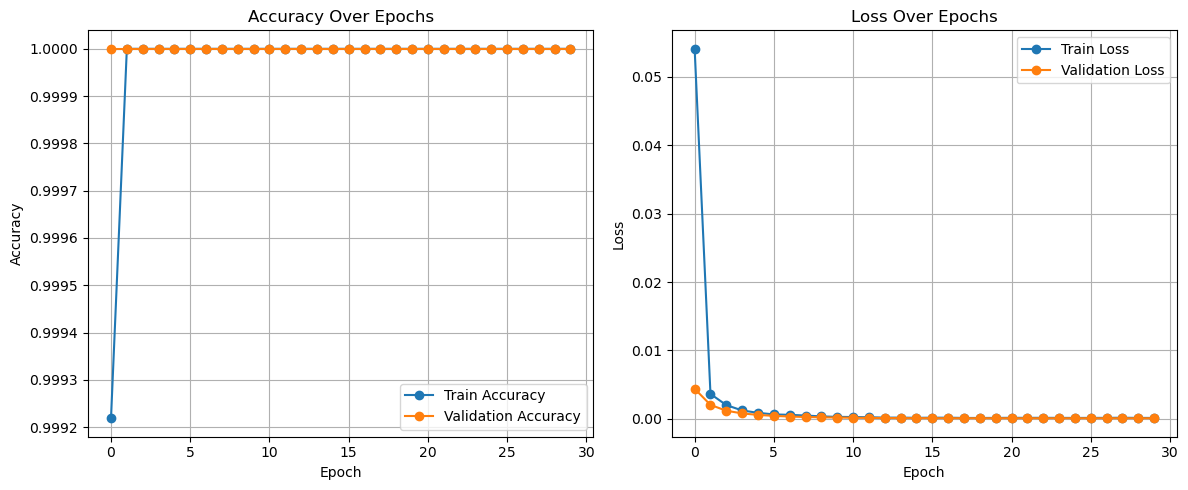


✅ Final model saved as 'final_pancreatic_model.h5'



✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Cancer Detected


In [2]:

# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

# Data directories
train_dir = r"D:\main\train"
test_dir =  r"D:\main\test"

# Data augmentation for training (stronger augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    shear_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescale for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load train data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Calculate class weights to balance dataset
labels_count = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_count),
    y=labels_count
)
class_weights = dict(enumerate(class_weights))
print("\n✅ Class Weights computed:", class_weights)

# Build model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

# Train model with class weights
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# ➡️ Visualization BEFORE saving the model
# Plot training & validation accuracy and loss

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ➡️ Save the final model
model.save('final_pancreatic_model.h5')
print("\n✅ Final model saved as 'final_pancreatic_model.h5'")

# --------------------------------------------------------

# Load the saved model
model = load_model('final_pancreatic_model.h5')
print("\n✅ Model loaded successfully.")

# Predict on a single image
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        print("Prediction: No Cancer")
    else:
        print("Prediction: Cancer Detected")

# Example to predict
predict_image(r"D:\1-008.jpg")


In [4]:
# Import necessary libraries
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model('final_pancreatic_model.h5')
print("✅ Model loaded successfully.")

# Prediction function
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        print("Prediction: No Cancer")
    else:
        print("Prediction: Cancer Detected")

# --- User input ---
img_path = input("Enter the full path to the image: ").strip()

# --- Predict ---
predict_image(img_path)


✅ Model loaded successfully.


Enter the full path to the image:  D:\1-009.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction: Cancer Detected
